In [1]:
from sentinel_dataset import SentinelWaterDataset
from model import UNet
from torch.utils.data import DataLoader
from tqdm import tqdm

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(in_channels=4, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
tile_size = 256
batch_size = 16

In [3]:
train_dataset = SentinelWaterDataset("sentinel2", tile_size=tile_size, mode='train')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SentinelWaterDataset("sentinel2", tile_size=tile_size, mode='val')
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

/mnt/c/job/repos/Remote-Sensing-Waterway-Segmentation/sentinel_dataset.py:86: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir)


In [4]:
def iou_score(pred_mask, true_mask, num_classes=2, smooth=1e-6): # per class
    ious = []
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls).float()
        true_cls = (true_mask == cls).float()
        intersection = (pred_cls * true_cls).sum()
        union = pred_cls.sum() + true_cls.sum() - intersection
        ious.append((intersection + smooth) / (union + smooth))
    return ious 

def dice_coef(pred_mask, true_mask, num_classes=2, smooth=1e-6):
    dices = []
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls).float()
        true_cls = (true_mask == cls).float()
        intersection = (pred_cls * true_cls).sum()
        dices.append((2 * intersection + smooth) / (pred_cls.sum() + true_cls.sum() + smooth))
    return dices

# Training

In [5]:
def single_epoch(model, train_dataloader, val_dataloader, device, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)  # pred shape: (B, 2, H, W)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
   
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    iou_list = []
    dice_list = []
    with torch.no_grad():
        for x, y in tqdm(val_dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            val_loss += loss.item()

            # compute accuracy
            pred_mask = torch.argmax(pred, dim=1)
            correct += (pred_mask == y).sum().item()
            total += y.numel()
            ious = iou_score(pred_mask, y)
            dices = dice_coef(pred_mask, y)
            iou_list.append(ious)
            dice_list.append(dices)

    val_loss /= len(val_dataloader)
    running_loss /= len(train_dataloader)
    val_acc = correct / total
    mean_iou = torch.tensor(iou_list).float().mean(0).detach().numpy()
    mean_dice = torch.tensor(dice_list).float().mean(0).detach().numpy()
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | IoU: {mean_iou} | Dice: {mean_dice}")

for epoch in range(num_epochs):
    print('EPOCH: ', epoch+1)
    single_epoch(model, train_dataloader, val_dataloader, device, criterion, optimizer)

EPOCH:  1


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:05<00:00, 51.08it/s]


Epoch 1/10 | Train Loss: 0.2071 | Val Loss: 0.1127 | Val Acc: 0.9969 | IoU: [0.9968247 0.7092605] | Dice: [0.99840903 0.81244904]
EPOCH:  2


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:09<00:00, 32.71it/s]


Epoch 2/10 | Train Loss: 0.0685 | Val Loss: 0.0495 | Val Acc: 0.9979 | IoU: [0.9978845 0.7614952] | Dice: [0.9989408 0.8501893]
EPOCH:  3


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:12<00:00, 23.39it/s]


Epoch 3/10 | Train Loss: 0.0341 | Val Loss: 0.0260 | Val Acc: 0.9981 | IoU: [0.99805063 0.757505  ] | Dice: [0.99902403 0.8424931 ]
EPOCH:  4


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:12<00:00, 24.11it/s]


Epoch 4/10 | Train Loss: 0.0207 | Val Loss: 0.0177 | Val Acc: 0.9981 | IoU: [0.99805987 0.7671266 ] | Dice: [0.9990288 0.848884 ]
EPOCH:  5


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:15<00:00, 19.89it/s]


Epoch 5/10 | Train Loss: 0.0138 | Val Loss: 0.0115 | Val Acc: 0.9983 | IoU: [0.9982785  0.79004633] | Dice: [0.99913824 0.8688226 ]
EPOCH:  6


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:12<00:00, 24.23it/s]


Epoch 6/10 | Train Loss: 0.0102 | Val Loss: 0.0100 | Val Acc: 0.9983 | IoU: [0.998257  0.7837383] | Dice: [0.9991275 0.865519 ]
EPOCH:  7


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:12<00:00, 25.18it/s]


Epoch 7/10 | Train Loss: 0.0080 | Val Loss: 0.0081 | Val Acc: 0.9984 | IoU: [0.9983449 0.7986822] | Dice: [0.9991716  0.87657946]
EPOCH:  8


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:11<00:00, 26.03it/s]


Epoch 8/10 | Train Loss: 0.0068 | Val Loss: 0.0064 | Val Acc: 0.9984 | IoU: [0.99837685 0.79521686] | Dice: [0.9991876 0.873179 ]
EPOCH:  9


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:15<00:00, 19.68it/s]


Epoch 9/10 | Train Loss: 0.0058 | Val Loss: 0.0054 | Val Acc: 0.9986 | IoU: [0.99855936 0.8315314 ] | Dice: [0.99927896 0.90078264]
EPOCH:  10


100%|█████████████████████████████████████████████████████████████████████████████████| 303/303 [00:13<00:00, 22.23it/s]


Epoch 10/10 | Train Loss: 0.0052 | Val Loss: 0.0048 | Val Acc: 0.9987 | IoU: [0.9986832  0.81709766] | Dice: [0.99934113 0.8867268 ]


# Visualization

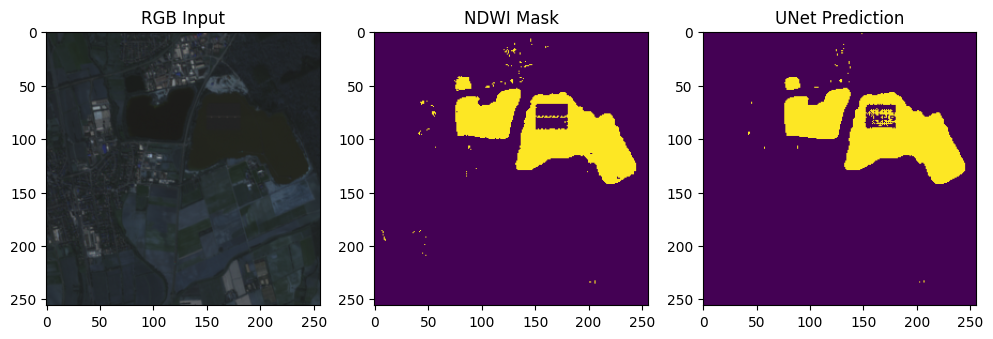

In [8]:
model.eval()
with torch.no_grad():
    for x, y in val_dataloader:
        if y[0].sum() > 150:
            x = x.to(device)
            pred = model(x)
            pred_mask = torch.argmax(pred, dim=1).cpu().numpy()
            break

# visualize first tile
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(np.transpose(x[0][:3].cpu().numpy(), (1,2,0)))  # RGB
plt.title("RGB Input")

plt.subplot(1,3,2)
plt.imshow(y[0].cpu().numpy())
plt.title("NDWI Mask")

plt.subplot(1,3,3)
plt.imshow(pred_mask[0])
plt.title("UNet Prediction")
plt.show()